In [3]:
import lightgbm
import pandas as pd
import numpy as np

from pathlib import Path
from tqdm import tqdm
import pickle as pkl

from testbed.models.ngboost import NGBoostGaussian, NGBoostMixtureGaussian
from testbed.models.treeffuser import Treeffuser

from functools import partial

from jaxtyping import Float, Array
from typing import List, Callable

import seaborn as sns
import matplotlib.pyplot as plt
from testbed.metrics.log_likelihood import LogLikelihoodFromSamplesMetric

path = "../src/testbed/data/m5"

# load autoreload extension
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# These are config variables

PROCESS_FROM_SCRATCH = True
USE_SUBSET = True
CONTEXT_LENGTH = 20
RUN_DEPRECATED = False

In [5]:
# READ IN DATA

sell_prices_df = pd.read_csv(Path(path) / "sell_prices.csv")
sales_train_validation_df = pd.read_csv(Path(path) / "sales_train_validation.csv")
calendar_df = pd.read_csv(Path(path) / "calendar.csv")

print("\ncolumns of sell_prices_df:")
[print(col) for col in sell_prices_df.columns]
print("\ncolumns of sales_train_validation_df:")
[print(col) for col in sales_train_validation_df.columns if not col.startswith("d_")]
print("\ncolumns of calendar_df:") # ommit d_1, d_2, ..., d_1913
[print(col) for col in calendar_df.columns if not col.startswith("d_")]

""

# print number of zeros
print("number of zeros in sales_train_validation_df: ", (sales_train_validation_df == 0).sum().sum())


columns of sell_prices_df:
store_id
item_id
wm_yr_wk
sell_price

columns of sales_train_validation_df:
id
item_id
dept_id
cat_id
store_id
state_id

columns of calendar_df:
date
wm_yr_wk
weekday
wday
month
year
d
event_name_1
event_type_1
event_name_2
event_type_2
snap_CA
snap_TX
snap_WI
number of zeros in sales_train_validation_df:  39777094


In [6]:
items_sold_cols = sales_train_validation_df.columns[sales_train_validation_df.columns.str.startswith("d_")]
num_zeros = (sales_train_validation_df[items_sold_cols] == 0).sum().sum()
total_entries = sales_train_validation_df[items_sold_cols].shape[0] * sales_train_validation_df[items_sold_cols].shape[1]

print(f"number of zeros in sales_train_validation_df: {num_zeros} out of {total_entries} entries")
print(f"percentage of zeros in sales_train_validation_df: {num_zeros / total_entries * 100:.2f}%")

number of zeros in sales_train_validation_df: 39777094 out of 58327370 entries
percentage of zeros in sales_train_validation_df: 68.20%


In [7]:
# add explicit columns for the day, month, year for ease of processing
calendar_df["date"] = pd.to_datetime(calendar_df["date"])
calendar_df["day"] = calendar_df["date"].dt.day
calendar_df["month"] = calendar_df["date"].dt.month
calendar_df["year"] = calendar_df["date"].dt.year


# Brief snapshots of the dataset

In [8]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,29
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,30
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,31
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,2


In [9]:
sales_train_validation_df.iloc[:10, :20]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,0,4,6,5,7,0,13,2,2,20
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,0,2,3,9,0,0,4,3,1,0
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,0,0,0,0,0,0,0,0,0,2


In [10]:
sales_train_validation_df.shape

(30490, 1919)

In [11]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Process the data

In [12]:
TOTAL_ITEMS = 1_000
# select a random subset of items
if USE_SUBSET:
    np.random.seed(0)
    unique_ids = sales_train_validation_df["id"].unique()
    ids = np.random.choice(sales_train_validation_df["id"].unique(), TOTAL_ITEMS, replace=False)
    sales_train_validation_df_sub = sales_train_validation_df[sales_train_validation_df["id"].isin(ids)]
    item_ids = sales_train_validation_df_sub["item_id"].unique()
    sell_prices_df_sub = sell_prices_df[sell_prices_df["item_id"].isin(item_ids)]
    calendar_df_sub = calendar_df





columns_sales_train_validation.head)

The strategy for processing the data is going to be the following. 1) We are going to have X and y where y is the next days sales for a given product. 3) X is made up of 10 previous prices, day of the week, + event types, cat_id, store_id, state_id

In [13]:
def proc_train_test(sales_train_validation_df: pd.DataFrame, calendar_df: pd.DataFrame, sell_prices_df: pd.DataFrame, context_length: int, test_days, percentage_omittied: int = 0): #type annotation too long
    """
    This function processes the data and returns the training and test data in two ways:
    - undifferentiated: a list of all training and test data (X_train, y_train, X_test, y_test)
    - differentiated: a list of training and test data for each product (X_train_prod, y_train_prod, X_test_prod, y_test_prod)
        where X_train_prod[i] contains a list of all X_train values for the product i with similar grouping for y_train_prod and test

    This assumes from the dataframes that
    - sales_train_validation_df:
        - has columns with the format d_1, d_2, ...
        - has columns item_id and store_id
    - calendar_df:
        - wday, month, event_name_1, event_name_2
    - sell_prices_df:
        - item_id, store_id, sell_price

    - percentage_omittied: percentage of the data to be omitted from the training data and the test data
        (randomly selected)

    Returns:
    - undifferentiated: Tuple of X_train, y_train, X_test, y_test
    - differentiated: Tuple of X_train_prod, y_train_prod, X_test_prod, y_test_prod
    """
    np.random.seed(0)
    # First we need to get the training data
    # We will use the first 1913 days as training data and the next

    X_train = []
    y_train = []

    X_test = []
    y_test = []

    # We will also return a second grouping of lists where X_train_prod[i] contains a
    # a list of all X_train values for the product i with similar grouping for y_train_prod and test
    X_train_prod = []
    y_train_prod = []
    X_test_prod = []
    y_test_prod = []


    # get all days that start with d_ and look for the maximum
    total_days = max([int(x.split("_")[1]) for x in sales_train_validation_df.columns if "d_" in x])
    train_days = total_days - test_days
    print("train days", train_days)
    print("test days", total_days - train_days)
    print("total days", total_days)

    # Precompute the required data
    calendar_df_dict = calendar_df.set_index("d").to_dict(orient="index")
    sell_prices_dict = sell_prices_df.groupby(["item_id", "store_id"])["sell_price"].first().to_dict()

    pbar = tqdm(total=len(sales_train_validation_df))
    for _, row in sales_train_validation_df.iterrows():
        item_id = row["item_id"]
        store_id = row["store_id"]

        X_train_prod.append([])
        y_train_prod.append([])
        X_test_prod.append([])
        y_test_prod.append([])

        pbar.update(1)

        valid_size = int((train_days - context_length) * (1 - percentage_omittied))
        valid_js = np.random.choice(range(1, train_days - context_length), valid_size, replace=False)

        valid_js = list(valid_js) + list(range(train_days - context_length, total_days - context_length))

        for j in valid_js:
            x = []

            # Add sales values for the previous context_length days
            x.extend(row[f"d_{j+k}"] for k in range(context_length))

            # Add additional features
            current_day = f"d_{j+context_length}"
            calendar_data = calendar_df_dict[current_day]
            x.extend([
                calendar_data["wday"],
                calendar_data["month"],
                store_id,
                calendar_data["event_name_1"],
                calendar_data["event_name_2"],
                sell_prices_dict[(item_id, store_id)],
                item_id,
                j + context_length
            ])

            if j < train_days:
                X_train.append(x)
                y_train.append(row[current_day])
                X_train_prod[-1].append(x)
                y_train_prod[-1].append(row[current_day])

            else:
                X_test.append(x)
                y_test.append(row[current_day])
                X_train_prod[-1].append(x)
                y_train_prod[-1].append(row[current_day])

    undifferentiated = (X_train, y_train, X_test, y_test)
    differentiated = (X_train_prod, y_train_prod, X_test_prod, y_test_prod)
    return undifferentiated, differentiated

In [14]:
if PROCESS_FROM_SCRATCH:
    undifferentiated, differentiated = proc_train_test(sales_train_validation_df_sub, calendar_df, sell_prices_df_sub, CONTEXT_LENGTH, 30, 0.99)
    X_train, y_train, X_test, y_test = undifferentiated
    X_train_prod, y_train_prod, X_test_prod, y_test_prod = differentiated


train days 1883
test days 30
total days 1913


100%|██████████| 1000/1000 [00:01<00:00, 999.40it/s]


In [15]:
len(X_train), len(y_train), len(X_test), len(y_test)

(38000, 38000, 10000, 10000)

In [16]:
COL_NAMES = [
    f"day_{i}" for i in range(1, CONTEXT_LENGTH+1)
] + ["wday", "month", "store_id", "event_name_1", "event_name_2", "sell_price", "item_id", "day"]

CAT_COLS = ["store_id", "event_name_1", "event_name_2", "item_id", "wday", "month"]
CAT_COLS_IDX = [COL_NAMES.index(col) for col in CAT_COLS]


In [17]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
y_train_df = pd.DataFrame(y_train)

X_train_df.columns = COL_NAMES
X_test_df.columns = COL_NAMES

In [18]:

X_train_df

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_19,day_20,wday,month,store_id,event_name_1,event_name_2,sell_price,item_id,day
0,8,3,4,2,5,2,4,5,9,2,...,13,12,6,6,CA_1,NaN,NaN,0.5,HOBBIES_1_019,1245
1,0,0,0,0,0,0,0,0,0,0,...,0,0,6,6,CA_1,NaN,NaN,0.5,HOBBIES_1_019,496
2,0,0,1,17,10,7,6,8,8,0,...,2,15,1,7,CA_1,NaN,NaN,0.5,HOBBIES_1_019,1625
3,0,14,2,0,1,5,15,0,2,0,...,5,3,2,6,CA_1,NaN,NaN,0.5,HOBBIES_1_019,1220
4,0,0,0,0,0,0,0,0,0,0,...,0,0,4,4,CA_1,NaN,NaN,0.5,HOBBIES_1_019,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37995,4,2,0,5,3,2,0,5,7,3,...,0,0,1,4,WI_3,NaN,NaN,1.0,FOODS_3_827,1898
37996,2,0,5,3,2,0,5,7,3,1,...,0,1,2,4,WI_3,NaN,NaN,1.0,FOODS_3_827,1899
37997,0,5,3,2,0,5,7,3,1,4,...,1,0,3,4,WI_3,NaN,NaN,1.0,FOODS_3_827,1900
37998,5,3,2,0,5,7,3,1,4,3,...,0,0,4,4,WI_3,NaN,NaN,1.0,FOODS_3_827,1901


In [19]:
# Encode the categorical columns as numbers
from sklearn.preprocessing import LabelEncoder
# Get only label of item_id
X_train_df["item_id"] = X_train_df["item_id"].apply(lambda x: x.split("_")[1])
X_test_df["item_id"] = X_test_df["item_id"].apply(lambda x: x.split("_")[1])


label_encoders = {}
for col in CAT_COLS:
    le = LabelEncoder()
    X_train_df[col] = le.fit_transform(X_train_df[col])
    X_test_df[col] = le.transform(X_test_df[col])
    label_encoders[col] = le


X_train_prod_processed = []
X_test_prod_processed = []
for i in range(len(X_train_prod)):
    X_train_prod_processed.append(pd.DataFrame(X_train_prod[i], columns=COL_NAMES))
    X_test_prod_processed.append(pd.DataFrame(X_test_prod[i], columns=COL_NAMES))
    X_train_prod_processed[-1]["item_id"] = X_train_prod_processed[-1]["item_id"].apply(lambda x: x.split("_")[1])
    X_test_prod_processed[-1]["item_id"] = X_test_prod_processed[-1]["item_id"].apply(lambda x: x.split("_")[1])
    for col in CAT_COLS:
        X_train_prod_processed[-1][col] = label_encoders[col].transform(X_train_prod_processed[-1][col])
        X_test_prod_processed[-1][col] = label_encoders[col].transform(X_test_prod_processed[-1][col])

X_train_df.head()


,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_19,day_20,wday,month,store_id,event_name_1,event_name_2,sell_price,item_id,day
0,8,3,4,2,5,2,4,5,9,2,...,13,12,5,5,0,30,4,0.5,0,1245
1,0,0,0,0,0,0,0,0,0,0,...,0,0,5,5,0,30,4,0.5,0,496
2,0,0,1,17,10,7,6,8,8,0,...,2,15,0,6,0,30,4,0.5,0,1625
3,0,14,2,0,1,5,15,0,2,0,...,5,3,1,5,0,30,4,0.5,0,1220
4,0,0,0,0,0,0,0,0,0,0,...,0,0,3,3,0,30,4,0.5,0,74


# PPC

### "Standard PPCs"

In [20]:

def max_ppc(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], number=0, name="") -> None:
    # rpeat y_true to match the shape of y_samples
    max_ppc = np.max(y_samples, axis=1)
    true_max = np.max(y_true)

    return max_ppc.flatten(), true_max.flatten(), "max_ppc"

def quantile_ppc(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], quantile=0.5, number=0, name="") -> None:
    # rpeat y_true to match the shape of y_samples
    q = np.quantile(y_samples, quantile, axis=1)
    true_q = np.quantile(y_true, quantile)
    return q.flatten(), true_q.flatten(), f"quantile_ppc_{quantile}"

def zeros(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], number=0, name="") -> None:
    "Count the number of zeros in the samples"
    zeros = np.sum(y_samples < 0.1, axis=1)
    true_zeros = np.sum(y_true < 0.1)

    return zeros.flatten(), true_zeros.flatten(), "zeros"

In [21]:
def plot_ppcs(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], ppcs: List[Callable],
              number=0, name="") -> None:
    # plot the distribution of

    for ppc in ppcs:
        ppc(y_true, y_samples, number=number, name=name)

### "Complex PPCs"

In [22]:

def plot_model_comparisons(data, y_true, figsize=(12, 8), model_names=None):
    """
    Plots model predictions against true values for each day.

    :param data: numpy array of shape [models, samples, days] containing model predictions
    :param y_true: array of shape [days] containing the true values
    :param figsize: tuple indicating the size of the figure
    """
    sns.set(style="whitegrid")
    models, samples, days = data.shape

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=figsize)

    # We will transform the data to a format suitable for seaborn
    # Create a DataFrame with model, day, and sample values
    plot_data = []
    if model_names is None:
        model_names = [f"Model {i}" for i in range(models)]

    for model_idx in range(models):
        for day_idx in range(days):
            for sample_idx in range(samples):
                plot_data.append({
                    "Day": day_idx,
                    "Value": data[model_idx, sample_idx, day_idx],
                    "Model": model_names[model_idx]
                })

    import pandas as pd
    plot_data = pd.DataFrame(plot_data)

    # Use seaborn to plot the boxplots
    sns.boxplot(x="Day", y="Value", hue="Model", data=plot_data, ax=ax, width=0.6)

    # Plot true values
    plt.plot(y_true, 'o', color='red', label='True Values')

    # Setting labels and title
    plt.xticks(ticks=np.arange(days), labels=[f"Day {i+1}" for i in range(days)])
    plt.xlabel('Days')
    plt.ylabel('Values')
    plt.title('Model Predictions vs. True Values')
    plt.legend()

    # Show the plot
    plt.show()







# Model Evaluation

In [23]:
def save_results_to_pkl(results: dict, dir_name, name):
    if not Path(dir_name).exists():
        Path(dir_name).mkdir(parents=True)

    path = Path(dir_name) / f"{name}.pkl"
    with open(path, "wb") as f:
        pkl.dump(results, f)


def load_results_from_pkl(dir_name, name):
    path = Path(dir_name) / f"{name}.pkl"
    with open(path, "rb") as f:
        results = pkl.load(f)
    return results


In [24]:
# Simple helper function to train a model and plot ppcs

def get_ppcs(y_samples, X_test, y_test, ppcs, number=0, name="") -> None:
    """
    Returns a dictionary with the samples and the true values for each ppc
    the dictionary a
    """
    y_samples = np.array(y_samples)
    y_samples = np.maximum(y_samples, 0)
    y_samples = np.round(y_samples, 0)

    ppc_results = {}
    for ppc in ppcs:
        samples, true, name = ppc(y_test, y_samples, number=number, name=name)
        ppc_results[name] = {"samples": samples, "true": true}

    return ppc_results


In [25]:
print(X_train_df.head())

   day_1  day_2  day_3  day_4  day_5  day_6  day_7  day_8  day_9  day_10  ...  \
0      8      3      4      2      5      2      4      5      9       2  ...   
1      0      0      0      0      0      0      0      0      0       0  ...   
2      0      0      1     17     10      7      6      8      8       0  ...   
3      0     14      2      0      1      5     15      0      2       0  ...   
4      0      0      0      0      0      0      0      0      0       0  ...   

   day_19  day_20  wday  month  store_id  event_name_1  event_name_2  \
0      13      12     5      5         0            30             4   
1       0       0     5      5         0            30             4   
2       2      15     0      6         0            30             4   
3       5       3     1      5         0            30             4   
4       0       0     3      3         0            30             4   

   sell_price  item_id   day  
0         0.5        0  1245  
1         0.5     

# Achille! 
Behold! The day :)

In [76]:
X_test_df["day"].value_counts()

day
1903    1000
1904    1000
1905    1000
1906    1000
1907    1000
1908    1000
1909    1000
1910    1000
1911    1000
1912    1000
Name: count, dtype: int64

In [61]:
EVAL_VALUES = 10000 # How many test points to use
np.random.seed(0)

eval_idx = np.random.choice(len(X_test_df), EVAL_VALUES, replace=False)

X_train_np = X_train_df.values[:, :-1]
X_days_np = X_train_df["day"].values
X_test_np = X_test_df.values[eval_idx][:, :-1]
X_test_days_np = X_test_df["day"].values[eval_idx]
X_test_df_sub = X_test_df.iloc[eval_idx]

y_train_np = y_train_df.values
y_test_np = y_test_df.values[eval_idx]

# change to float to prevent errors
y_train_np = y_train_np.astype(np.float32)
y_test_np = y_test_np.astype(np.float32)


In [62]:
from testbed.models.ngboost import NGBoostPoisson
from testbed.models.quantile_regression import QuantileRegressionTree
from testbed.models.ibug_ import IBugXGBoost
from testbed.models.treeffuser import Treeffuser
# from testbed.models.lightning_uq_models import DeepEnsemble


MODEL_CLASSES = [Treeffuser, NGBoostGaussian, NGBoostPoisson, QuantileRegressionTree, IBugXGBoost]
NAMES = ["Treeffuser", "NGBoostGaussian", "NGBoostPoisson", "QuantileRegressionTree", "IBugXGBoost"]

NUM_SAMPLES = 100
# HYPERS = [
#     {"subsample": 0.20, "subsample_freq": 1, "verbose": 1, "num_leaves":129, "learning_rate":0.5,
#      "sde_manual_hyperparams": {"hyperparam_max": 10}},
#     {}
# ]

results = []
for i in range(len(MODEL_CLASSES)):
    print(f"Fitting model {NAMES[i]}")
    model_cls = MODEL_CLASSES[i]
    # model = model_cls(**HYPERS[i])
    model = model_cls()
    model.fit(X_train_np, y_train_np)

    results.append({
        "model": model,
        "model_name": NAMES[i]
    })




Fitting model Treeffuser
Fitting model NGBoostGaussian


/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/ngboost/distns/normal.py:71: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/ngboost/distns/normal.py:72: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


Fitting model NGBoostPoisson
Fitting model QuantileRegressionTree


/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/lightgbm/basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Using self-defined objective function
Fitting model IBugXGBoost


/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [63]:

for i, result in enumerate(results):
    model = result["model"]
    model_name = result["model_name"]
    y_samples = model.sample(X_test_np, NUM_SAMPLES)
    results[i]["y_samples"] = y_samples

/Users/achille/miniconda3/envs/treefuse/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [68]:
# implement the newsvendor utility function

def newsvendor_utility(
    y_true: Float[Array, "batch 1"], quantity_ordered : Float[Array, "batch 1"], prices : Float[Array, "batch 1"],
    stocking_cost: Float[Array, "batch 1"]
    ) -> Float[Array, "batch 1"]:
    """
    The newsvendor utility function with stock q, demand y, selling price p, stocking cost c is given by
    U(y, q, p, c) = p * min(y, q) - c * q
    """
    y_true = y_true.flatten()
    utility = prices * np.minimum(y_true, quantity_ordered) - stocking_cost * quantity_ordered
    return utility

def newsvendor_optimal_quantity(y_samples: Float[Array, "samples batch 1"], 
prices: Float[Array, "batch 1"], stocking_cost: Float[Array, "batch 1"]) -> Float[Array, "batch 1"]:
    """
    Returns the optimal quantity to order for the newsvendor problem.
    It is given theoeretically by:
    q* = argmax_{q} E[U(y, q, p, c)] which has a closed form solution
    q* = F^{-1}( (p - c) / p)
    where F is the CDF of the demand distribution
    """
    # compute the target quantiles (p - c) / p
    target_quantiles = (prices - stocking_cost) / prices
    target_quantiles = np.maximum(target_quantiles, 0.0)
    
    # compute the empirical quantities corresponding to the target quantiles
    
    res = []
    for i in range(y_samples.shape[1]):
        optimal_quantities = np.quantile(y_samples[:,i,0], target_quantiles[i])
        res.append(optimal_quantities)
    optimal_quantities = np.array(res)
    return optimal_quantities
    
    
def evaluate_models(results, X_test_df, y_test):
    """
    Evaluates the model on the test data
    """
    prices = X_test_df["sell_price"].values
    profit_margin = 0.5
    stocking_cost =  prices / (1 + profit_margin)
    
    
    # compute the maximum utility if we had perfect information
    perfect_quantities = np.maximum(y_test.flatten(), 0)
    perfect_utility = newsvendor_utility(y_test, perfect_quantities, prices, stocking_cost)
    print(f"Knowing the perfect demand would make that much moolah: ${perfect_utility.sum():.2f}")
    
    # print all shapes
    res_df = pd.DataFrame({
        "day": X_test_df["day"].values,
        "y_true": y_test.flatten(),
        "sell_price": prices,
        "stocking_cost": stocking_cost,
        "perfect_quantities": perfect_quantities,
    })
    
    for tmp in results:
        model_name = tmp["model_name"]
        y_samples = tmp["y_samples"]
        optimal_quantities = newsvendor_optimal_quantity(y_samples, prices, stocking_cost)
        utility = newsvendor_utility(y_test, optimal_quantities, prices, stocking_cost)
        res_df[f"{model_name}_quantities"] = optimal_quantities
        res_df[f"{model_name}_utility"] = utility
        print(f"Model {model_name} makes {utility.sum():.2f} big bucks! {'😊' if utility.sum() > 0 else '😢'}")
        
    return res_df
    
    
    

Knowing the perfect demand would make that much moolah: $13442.67
Model Treeffuser makes 1953.06 big bucks! 😊
Model NGBoostGaussian makes -315781934.02 big bucks! 😢
Model NGBoostPoisson makes 2116.61 big bucks! 😊
Model QuantileRegressionTree makes 1362.75 big bucks! 😊
Model IBugXGBoost makes -848.90 big bucks! 😢


<Axes: xlabel='day'>

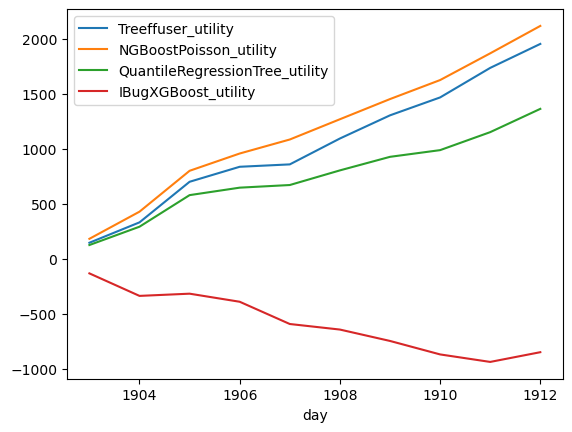

In [74]:
res_df = evaluate_models(results, X_test_df_sub, y_test_np)

# res_df_pivot = res_df.pivot_table(index="day", columns="model_name", values=["utility"], aggfunc="sum")
res_df_pivot = res_df.groupby("day").sum()[[f"{model_name}_utility" for model_name in NAMES]]
# remove NGBoostGaussian
res_df_pivot = res_df_pivot.drop(columns="NGBoostGaussian_utility")
res_df_pivot = res_df_pivot.sort_index()
# cumsum
res_df_pivot = res_df_pivot.cumsum()
res_df_pivot.plot()


Now we can actually fit some of the models

In [ ]:
ppcs = [max_ppc, zeros] + [partial(quantile_ppc, quantile=q) for q in [0.1, 0.5, 0.9, 0.99]]

for i, model_cls in enumerate(MODEL_CLASSES):
    ppc_results = get_ppcs(
        y_samples=results[i]["y_samples"],
        X_test=X_test_np,
        y_test=y_test_np,
        ppcs=ppcs,
        number=i,
        name=model_cls.__name__
    )
    results[i]["ppc_results"] = ppc_results


# Plot the PPCs

In [ ]:
def proc_title(title):
    x = title.replace("_", " ").capitalize()
    x = x.replace("ppc", "PPC")
    return x

ppc_number = len(ppcs)
ppc_names = results[0]["ppc_results"].keys()

for ppc_name in ppc_names:
    fig, ax = plt.subplots()
    for i, res in enumerate(results):
        model_name = res["model_name"]
        samples = res["ppc_results"][ppc_name]["samples"]
        # make int
        samples = np.maximum(samples, 0)
        samples =  np.round(samples)
        true = res["ppc_results"][ppc_name]["true"]
        n_unique_samples = len(np.unique(samples))
        discrete = n_unique_samples < 20

        # plot a histogram of the samples but with integers
        sns.histplot(samples, ax=ax, label=f"{model_name} samples", discrete=discrete, stat="density")
        ax.axvline(true, color="red", label="true")
        ax.set_title(proc_title(f"{ppc_name}"))
        ax.legend()

        if n_unique_samples < 2:
            min_val = np.min(samples) - 1
            max_val = np.max(samples) + 1

            ax.set_xlim(min_val, max_val)

        max_x = true * 5
        max_samples = np.max(samples)
        if max_samples > max_x:
            ax.set_xlim(0, max_x)


    plt.show()





In [ ]:
np.random.seed(0)

NUM_PRODS_TO_PLOT = 3
DAYS_TO_PLOT = 10
QUATILE = 0.9
NUM_SAMPLES = 100

prods_to_plot = np.random.choice(range(len(X_train_prod_processed)), NUM_PRODS_TO_PLOT)

means_to_plot = []
lower_q_s = []
upper_q_s = []

prod_dict = {}

for res in results:
    model = res["model"]

    for i in prods_to_plot:
        if i not in prod_dict:
            prod_dict[i] = {
                "means_to_plot": [],
                "lower_q_s": [],
                "upper_q_s": [],
                "samples": []
            }

        X_prod_proc_i = X_train_prod_processed[i][-DAYS_TO_PLOT:]
        y_prod_proc_i = y_train_prod[i][-DAYS_TO_PLOT:]

        samples = model.sample(X_prod_proc_i.values, NUM_SAMPLES)
        samples = samples.astype(int)
        samples = np.maximum(samples, 0)

        means = np.mean(samples, axis=0)
        lower_q = np.quantile(samples, 1-QUATILE, axis=0)
        upper_q = np.quantile(samples, QUATILE, axis=0)

        prod_dict[i]["means_to_plot"].append(means)
        prod_dict[i]["lower_q_s"].append(lower_q)
        prod_dict[i]["upper_q_s"].append(upper_q)
        prod_dict[i]["samples"].append(samples)

for i in prod_dict:
    means_to_plot = np.array(prod_dict[i]["means_to_plot"]).squeeze()
    lower_q_s = np.array(prod_dict[i]["lower_q_s"]).squeeze()
    upper_q_s = np.array(prod_dict[i]["upper_q_s"]).squeeze()
    samples = np.array(prod_dict[i]["samples"]).squeeze()
    y_true = np.array(y_train_prod[i][-DAYS_TO_PLOT:])

    model_names = [res["model"].__class__.__name__ for res in results]

    print("mean shape", means_to_plot.shape)
    print("lower shape", lower_q_s.shape)
    print("upper shape", upper_q_s.shape)
    print("y_true shape", y_true.shape)
    print("samples shape", samples.shape)

    #plot_predictions(y_true, means_to_plot, upper_q_s, lower_q_s, [res["model"].__class__.__name__ for res in results])
    plot_model_comparisons(samples, y_true, model_names=model_names)


# Log-likelihood

In [ ]:
for res in results:
    model = res["model"]
    nll = LogLikelihoodFromSamplesMetric(n_samples=100).compute(model=model, X_test=X_test_np, y_test=y_test_np, samples=res["y_samples"])
    print(f"Model {model.__class__.__name__} has a NLL of {nll}")

# Plot calibration plot

In [ ]:
def calibration_plot(y_samples: Float[np.ndarray, "n_samples batch y_dim"], y_test: Float[np.ndarray, "batch y_dim"]) -> None:
    """
    We will plot the calibration plot for the model. Essentially, we will plot the
    """
    assert y_test.shape[1] == 1, "Only works for univariate outputs"
    n_samples = y_samples.shape[0]
    y_samples = np.maximum(y_samples, 0.0)
    y_samples = np.round(y_samples).astype(int)
    y_test = y_test.astype(int)

    # Filter out the zeros
    #non_zero_idx = y_test > 0
    #y_test = y_test[non_zero_idx]
    #y_samples = y_samples[:, non_zero_idx]

    y_test_expanded = y_test[np.newaxis, :].repeat(n_samples, axis=0)
    prob_of_event = np.mean(y_samples <= y_test_expanded, axis=0)
    prob_of_event_sorted = np.sort(prob_of_event.flatten())
    return np.linspace(0, 1, len(prob_of_event)), prob_of_event_sorted










In [ ]:
y_ex = None
for res in results:
    samples = res["y_samples"]
    model = res["model"]
    x,y = calibration_plot(samples, y_test_np)
    plt.plot(x, y, label=model.__class__.__name__)
    y_ex = y


plt.plot([0, 1], [0, 1], linestyle="--", color="black")

plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.legend()

plt.show()

# plot the distribution of y

sns.histplot(y_ex, bins=20)